In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
train = '/content/drive/MyDrive/Colab Notebooks/output/train'
test = '/content/drive/MyDrive/Colab Notebooks/output/test'
val = '/content/drive/MyDrive/Colab Notebooks/output/val'

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_shape = (224,224,3)
image_gen = ImageDataGenerator(rotation_range=20,
                               rescale=1/255,
                               horizontal_flip=True,
                               fill_mode='nearest'
                              )


In [ ]:
image_gen.flow_from_directory(train)
image_gen.flow_from_directory(test)
image_gen.flow_from_directory(val)

Found 5152 images belonging to 8 classes.
Found 644 images belonging to 8 classes.
Found 644 images belonging to 8 classes.


In [ ]:
train_image_gen = image_gen.flow_from_directory(train,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=32,
                                               class_mode='categorical')

test_image_gen = image_gen.flow_from_directory(test,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=32,
                                               class_mode='categorical',shuffle=True)

val_image_gen = image_gen.flow_from_directory(val,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=32,
                                               class_mode='categorical',shuffle=False)

Found 5152 images belonging to 8 classes.
Found 644 images belonging to 8 classes.
Found 644 images belonging to 8 classes.


In [ ]:
train_image_gen.class_indices

{'dyed-lifted-polyps': 0,
 'dyed-resection-margins': 1,
 'esophagitis': 2,
 'normal-cecum': 3,
 'normal-pylorus': 4,
 'normal-z-line': 5,
 'polyps': 6,
 'ulcerative-colitis': 7}

## INCEPTIONV3

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

In [ ]:
# Load the pre-trained InceptionV3 model without the top layer
base_modelv3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(224,224,3))


87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
x = base_modelv3.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
predictions1 = Dense(8, activation='softmax')(x)


In [ ]:
modelv3 = Model(inputs=base_modelv3.input, outputs=predictions1)

In [ ]:
for layer in base_modelv3.layers[:1]:
    layer.trainable = False


In [ ]:
modelv3.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
historyv3 = modelv3.fit(x=train_image_gen,
                      epochs=30,
                      validation_data=val_image_gen)


Epoch 1/30
161/161 [==============================] - 1343s 8s/step - loss: 0.8615 - accuracy: 0.7104 - val_loss: 0.4312 - val_accuracy: 0.8230
Epoch 2/30
161/161 [==============================] - 114s 708ms/step - loss: 0.2831 - accuracy: 0.8993 - val_loss: 0.2309 - val_accuracy: 0.9193
Epoch 3/30
161/161 [==============================] - 114s 708ms/step - loss: 0.1915 - accuracy: 0.9342 - val_loss: 0.2072 - val_accuracy: 0.9301
Epoch 4/30
161/161 [==============================] - 113s 704ms/step - loss: 0.1382 - accuracy: 0.9534 - val_loss: 0.1643 - val_accuracy: 0.9394
Epoch 5/30
161/161 [==============================] - 113s 704ms/step - loss: 0.1053 - accuracy: 0.9643 - val_loss: 0.1932 - val_accuracy: 0.9286
Epoch 6/30
161/161 [==============================] - 122s 756ms/step - loss: 0.0918 - accuracy: 0.9711 - val_loss: 0.1681 - val_accuracy: 0.9410
Epoch 7/30
161/161 [==============================] - 115s 713ms/step - loss: 0.0695 - accuracy: 0.9777 - val_loss: 0.1833 - v

In [ ]:
test_historyv3 = modelv3.evaluate(x=test_image_gen)

21/21 [==============================] - 166s 8s/step - loss: 0.1402 - accuracy: 0.9752


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


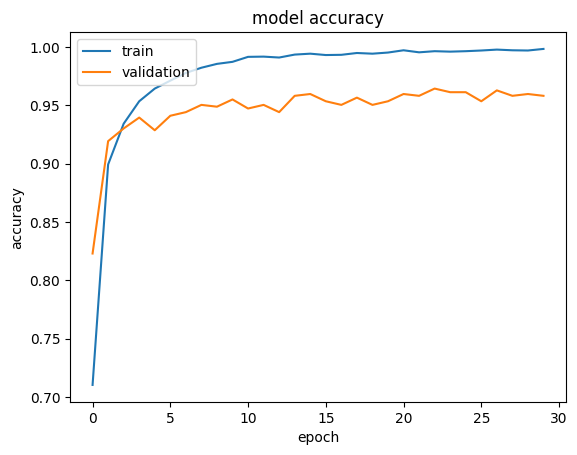

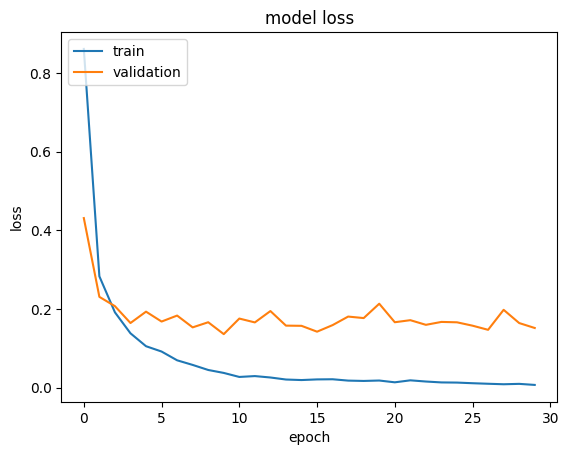

In [ ]:
print(historyv3.history.keys())
#  "Accuracy"
plt.plot(historyv3.history['accuracy'])
plt.plot(historyv3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(historyv3.history['loss'])
plt.plot(historyv3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
modelv3.save('/content/drive/MyDrive/Colab Notebooks/Endo-inception97.h5')

## DENSENET121

In [ ]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.densenet import DenseNet121


In [ ]:
# Define the number of classes
num_classes = len(train_image_gen.class_indices)

# Load the pre-trained model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224,224,3))



29084464/29084464 [==============================] - 3s 0us/step


In [ ]:
# Add a new classification layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)



In [ ]:
# Create the final model
dense_model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Compile the model
dense_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
historyd = dense_model.fit(train_image_gen, epochs=30, validation_data=val_image_gen)



Epoch 1/30
161/161 [==============================] - 4428s 27s/step - loss: 0.5946 - accuracy: 0.7921 - val_loss: 0.3911 - val_accuracy: 0.8665
Epoch 2/30
161/161 [==============================] - 123s 761ms/step - loss: 0.2146 - accuracy: 0.9210 - val_loss: 0.2184 - val_accuracy: 0.9130
Epoch 3/30
161/161 [==============================] - 126s 780ms/step - loss: 0.1603 - accuracy: 0.9451 - val_loss: 0.1900 - val_accuracy: 0.9255
Epoch 4/30
161/161 [==============================] - 125s 772ms/step - loss: 0.1116 - accuracy: 0.9594 - val_loss: 0.1699 - val_accuracy: 0.9394
Epoch 5/30
161/161 [==============================] - 133s 824ms/step - loss: 0.0864 - accuracy: 0.9676 - val_loss: 0.1473 - val_accuracy: 0.9425
Epoch 6/30
161/161 [==============================] - 133s 824ms/step - loss: 0.0682 - accuracy: 0.9783 - val_loss: 0.1443 - val_accuracy: 0.9534
Epoch 7/30
161/161 [==============================] - 132s 822ms/step - loss: 0.0540 - accuracy: 0.9829 - val_loss: 0.1185 - 

In [ ]:
test_historyd = dense_model.evaluate(x=test_image_gen)

21/21 [==============================] - 464s 23s/step - loss: 0.0945 - accuracy: 0.9767


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


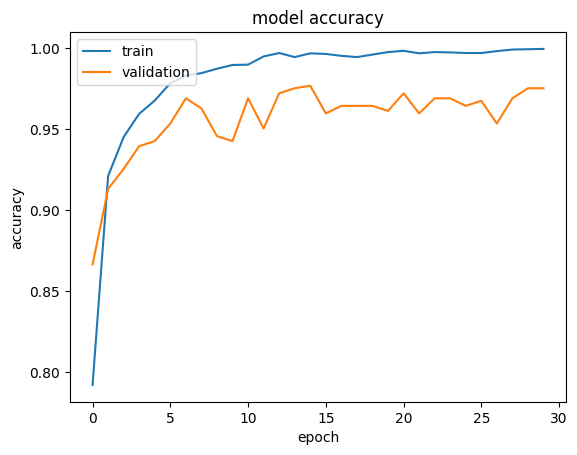

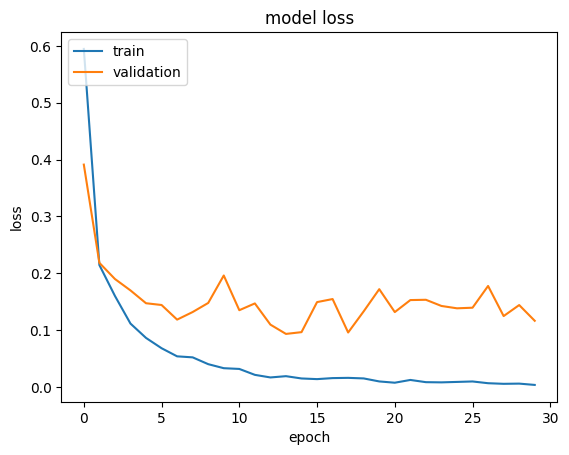

In [ ]:
print(historyd.history.keys())
#  "Accuracy"
plt.plot(historyd.history['accuracy'])
plt.plot(historyd.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(historyd.history['loss'])
plt.plot(historyd.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
dense_model.save('/content/drive/MyDrive/Colab Notebooks/Endo-DenseNet97.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## VGG

In [ ]:
from tensorflow.keras.applications import VGG16

In [ ]:
basic_vgg = VGG16(input_shape=(224,224,3),
                 include_top=False,
                 weights='imagenet')



In [ ]:
#for layer in basic_vgg.layers[:1]:
 #   layer.trainable = False

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout

In [ ]:
x=Flatten()(basic_vgg.output)
x=Dense(512,activation='relu')(x)
x=Dropout(0.3)(x)
x=Dense(8,activation='softmax')(x)

In [ ]:
modelvgg =tf.keras.Model(basic_vgg.input,x)
modelvgg.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
historyvgg = modelvgg.fit(x=train_image_gen,
                      epochs=25,
                      validation_data=val_image_gen)


Epoch 1/25
161/161 [==============================] - 127s 782ms/step - loss: 0.0276 - accuracy: 0.9909 - val_loss: 0.1839 - val_accuracy: 0.9441
Epoch 2/25
161/161 [==============================] - 124s 768ms/step - loss: 0.9100 - accuracy: 0.6988 - val_loss: 1.0769 - val_accuracy: 0.5373
Epoch 3/25
161/161 [==============================] - 125s 777ms/step - loss: 0.4859 - accuracy: 0.7937 - val_loss: 0.2758 - val_accuracy: 0.9022
Epoch 4/25
161/161 [==============================] - 124s 771ms/step - loss: 0.1271 - accuracy: 0.9521 - val_loss: 0.2257 - val_accuracy: 0.9161
Epoch 5/25
161/161 [==============================] - 126s 781ms/step - loss: 0.3169 - accuracy: 0.8903 - val_loss: 0.2204 - val_accuracy: 0.9208
Epoch 6/25
161/161 [==============================] - 126s 780ms/step - loss: 0.0713 - accuracy: 0.9742 - val_loss: 0.4883 - val_accuracy: 0.8323
Epoch 7/25
161/161 [==============================] - 124s 768ms/step - loss: 0.0597 - accuracy: 0.9800 - val_loss: 0.2210 -

In [ ]:
test_metrics = modelvgg.evaluate(x=test_image_gen)

21/21 [==============================] - 14s 651ms/step - loss: 0.1538 - accuracy: 0.9643


In [ ]:
# Print test set loss and accuracy if available
if len(test_metrics) == 2:
    test_loss, test_accuracy = test_metrics
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)
else:
    print("Unable to retrieve test set metrics.")

# Plot "Accuracy"
plt.plot(historyvgg.history['accuracy'])
plt.plot(historyvgg.history['val_accuracy'])
plt.title('Model Accuracy Over Epochs (VGG16)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot "Loss"
plt.plot(historyvgg.history['loss'])
plt.plot(historyvgg.history['val_loss'])
plt.title('Model Loss Over Epochs (VGG16)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Test Loss: 0.15378545224666595
Test Accuracy: 0.9642857313156128


AttributeError: ignored

In [ ]:
print(historyvgg.history.keys())
#  "Accuracy"
plt.plot(historyvgg.history['accuracy'])
plt.plot(historyvgg.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(historyvgg.history['loss'])
plt.plot(historyvgg.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

AttributeError: ignored

In [ ]:
modelvgg.save('/content/drive/MyDrive/Colab Notebooks/Endo-vgg16.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the pre-trained VGG16 model without the top layer
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x_vgg = base_model_vgg.output
x_vgg = GlobalAveragePooling2D()(x_vgg)
x_vgg = Dense(512, activation='relu')(x_vgg)
x_vgg = Dropout(0.2)(x_vgg)
predictions_vgg = Dense(8, activation='softmax')(x_vgg)
model_vgg = Model(inputs=base_model_vgg.input, outputs=predictions_vgg)

# Freeze the layers of the pre-trained model
#for layer in base_model_vgg.layers:
 #   layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model_vgg.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
history_vgg = model_vgg.fit(x=train_image_gen,
                            epochs=30,
                            validation_data=val_image_gen)

Epoch 1/30
 86/161 [===============>..............] - ETA: 1:18:01 - loss: 1.9590 - accuracy: 0.2235

In [ ]:
# Evaluate on the test set
test_history_vgg = model_vgg.evaluate(x=test_image_gen)

In [ ]:
# Print test set loss and accuracy
print("Test Loss:", test_history_vgg[0])
print("Test Accuracy:", test_history_vgg[1])

# Plot "Accuracy"
plt.plot(history_vgg.history['accuracy'])
plt.plot(history_vgg.history['val_accuracy'])
plt.title('Model Accuracy Over Epochs (VGG16)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot "Loss"
plt.plot(history_vgg.history['loss'])
plt.plot(history_vgg.history['val_loss'])
plt.title('Model Loss Over Epochs (VGG16)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Save the model
model_vgg.save('/content/drive/MyDrive/Colab Notebooks/Endo-vgg16p2.h5')